<a href="https://colab.research.google.com/github/lmEshoo/pruning/blob/master/mobilenetv2_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mobilenetv2 model pruning**

**Build Model**

In [2]:
import tensorflow as tf
tf.__version__
# !pip uninstall tensorflow -y
! pip uninstall -y tensorflow
! pip uninstall -y tf-nightly
!pip install tensorflow==2.1.0
# ! pip install -q -U tensorflow-gpu==1.14.0

! pip install -q tensorflow-model-optimization

Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 450kB 43.2MB/s 
     |████████████████████████████████| 3.9MB 38.2MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


     |████████████████████████████████| 102kB 5.6MB/s 


In [0]:
"""
# Reference
- [Inverted Residuals and Linear Bottlenecks Mobile Networks for
   Classification, Detection and Segmentation]
   (https://arxiv.org/abs/1801.04381)
"""

import tensorflow as tf

# Define ReLU6 activation
relu6 = tf.keras.layers.ReLU(6.)

def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.

    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.

    # Returns
        Output tensor.
    """

    x = tf.keras.layers.Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    return relu6(x)


def _bottleneck(inputs, filters, kernel, t, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.

    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.

    # Returns
        Output tensor.
    """

    tchannel = inputs.shape[-1] * t

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = relu6(x)

    x = tf.keras.layers.Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x


def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.

    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)

    return x


def MobileNetV2(input_shape, k, plot_model=False):
    """MobileNetv2
    This function defines a MobileNetv2 architecture.

    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        plot_model: Boolean, whether to plot model architecture or not
    # Returns
        MobileNetv2 model.
    """

    inputs = tf.keras.layers.Input(shape=input_shape, name='input')
    x = _conv_block(inputs, 32, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 16, (3, 3), t=1, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, strides=1, n=1)

    x = _conv_block(x, 1280, (1, 1), strides=(1, 1))
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Reshape((1, 1, 1280))(x)
    x = tf.keras.layers.Dropout(0.3, name='Dropout')(x)
    x = tf.keras.layers.Conv2D(k, (1, 1), padding='same')(x)
    x = tf.keras.layers.Activation('softmax', name='final_activation')(x)
    output = tf.keras.layers.Reshape((k,), name='output')(x)
    model = tf.keras.models.Model(inputs, output)
    model.summary()
    if plot_model:
        tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [0]:

%matplotlib inline
import matplotlib.pyplot as plt

class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [11]:
# Get CIFAR10
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
# rm cifar-10-python.tar.gz 

--2020-03-15 16:53:07--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  28.8MB/s    in 6.2s    

2020-03-15 16:53:13 (26.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [12]:
from six.moves import cPickle as pickle
import numpy as np
import os
from matplotlib.pyplot import imread
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

num_training=49000
num_validation=1000
num_test=10000
"""
Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
it for the two-layer neural net classifier. These are the same steps as
we used for the SVM, but condensed to a single function.  
"""
# Load the raw CIFAR-10 data
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Subsample the data
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# Normalize the data: subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

X_train, y_train, X_val, y_val, X_test, y_test


(array([[[[ -71.64189796,  -73.98173469,  -69.47391837],
          [ -87.05569388,  -89.34804082,  -86.75402041],
          [ -80.96055102,  -88.14328571,  -89.47636735],
          ...,
          [  27.08416327,   -4.17532653,  -24.29806122],
          [  21.74489796,  -10.5802449 ,  -29.8692449 ],
          [  17.94502041,  -11.36534694,  -28.78516327]],
 
         [[-114.02414286, -115.21683673, -111.27732653],
          [-129.26055102, -134.36308163, -130.36228571],
          [-112.13655102, -127.08104082, -130.99981633],
          ...,
          [  -6.92971429,  -47.03577551,  -75.78222449],
          [ -10.2192449 ,  -51.456     ,  -80.38761224],
          [  -7.05363265,  -47.29195918,  -73.35697959]],
 
         [[-104.66336735, -110.58489796, -109.18261224],
          [-112.65646939, -126.42697959, -128.94187755],
          [ -80.41834694, -106.98687755, -121.40087755],
          ...,
          [ -11.12879592,  -49.88912245,  -79.20440816],
          [  -8.51010204,  -49.470591

In [13]:
X_train.shape

(49000, 32, 32, 3)

In [0]:
"""
Train the MobileNet V2 model (https://github.com/xiaochus/MobileNetV2)
"""
import os
import sys
import argparse
import pandas as pd
import numpy as np
import tensorflow as tf

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Reshape, Activation
from keras.models import Model



def train(batch=64, epochs=50, num_classes=10, size=32):

    # train_generator, validation_generator, count1, count2 = generate(batch, size)



    print("{} classes found".format(num_classes))

    model = MobileNetV2((size, size, 3), num_classes, True)
    # model = new_pruned_model
    # opt = tf.keras.optimizers.Adam()
    opt = tf.keras.optimizers.SGD(lr=3e-3, momentum=0.9, decay=1e-6)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=30, verbose=1, mode='auto')
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])

    hist = model.fit(X_train, y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=1,
          callbacks=[earlystop,plot_losses],
          validation_data=(X_test, y_test))
    # model = MobileNetv2((size, size, 3), num_classes)
    # inp = Input(shape=(size, size, 3), batch_size=batch, dtype='float32')
    # model = Model((size, size, 3), MobileNetv2((size, size, 3),num_classes))

    # print(train_generator[-1], validation_generator[-1], count1, count2)
    # print(count1 // batch, count2 // batch)
    # # Optimizer = tf.keras.optimizers.Adam()
    # Optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.3, decay=0, nesterov=False)
    # model.compile(loss=tf.keras.losses.categorical_crossentropy,
    #                   optimizer=Optimizer,
    #                   metrics=['accuracy'])
    # earlystop = EarlyStopping(monitor='val_acc', patience=30, verbose=1, mode='auto')
    
    # model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # hist = model.fit_generator(
    #     train_generator,
    #     validation_data=validation_generator,
    #     steps_per_epoch=count1 // batch,
    #     validation_steps=count2 // batch,
    #     epochs=epochs,
    #     callbacks=[earlystop])
    
    # hist = model.fit(
    #     train_generator,
    #     validation_data=validation_generator,
    #     steps_per_epoch=count1 // batch,
    #     validation_steps=count2 // batch,
    #     epochs=epochs,
    #     callbacks=[earlystop],
    #     use_multiprocessing=True)

    if not os.path.exists('model'):
        os.makedirs('model')

    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('model/hist.csv', encoding='utf-8', index=False)
    model.save_weights('model/weights.h5')

    return model, batch


10 classes found
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 16, 16, 32)   896         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_265 (BatchN (None, 16, 16, 32)   128         conv2d_185[0][0]                 
__________________________________________________________________________________________________
re_lu (ReLU)                    multiple             0           batch_normalization_265[0][0]    
                                                                 batch_norm

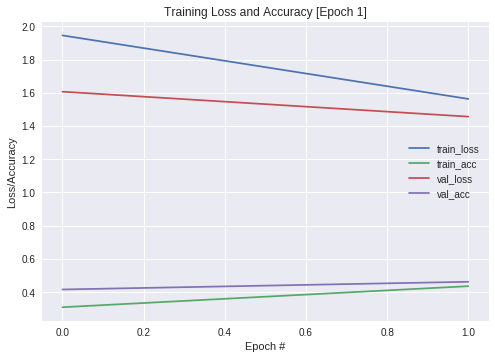

49000/49000 [==============================] - 19s 380us/sample - loss: 1.5631 - acc: 0.4359 - val_loss: 1.4565 - val_acc: 0.4623
Epoch 3/50
48832/49000 [============================>.] - ETA: 0s - loss: 1.4374 - acc: 0.4859

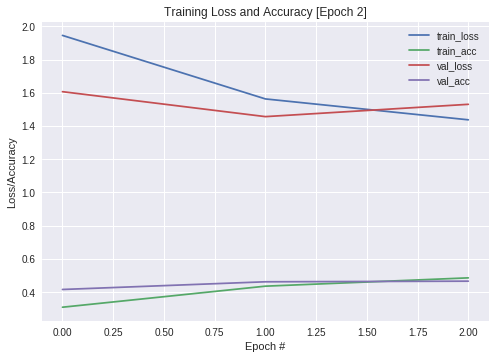

49000/49000 [==============================] - 18s 372us/sample - loss: 1.4374 - acc: 0.4859 - val_loss: 1.5306 - val_acc: 0.4660
Epoch 4/50
48960/49000 [============================>.] - ETA: 0s - loss: 1.3671 - acc: 0.5133

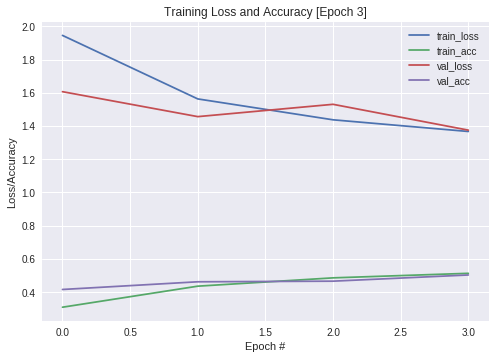

49000/49000 [==============================] - 18s 370us/sample - loss: 1.3671 - acc: 0.5132 - val_loss: 1.3752 - val_acc: 0.5033
Epoch 5/50
48896/49000 [============================>.] - ETA: 0s - loss: 1.2903 - acc: 0.5450

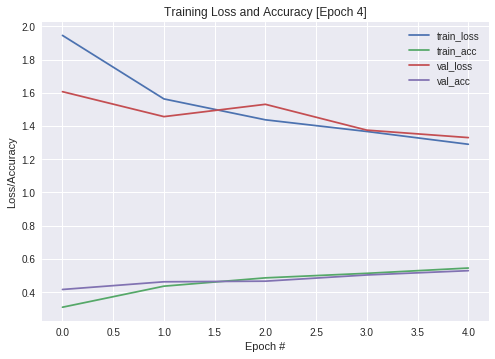

49000/49000 [==============================] - 18s 375us/sample - loss: 1.2902 - acc: 0.5451 - val_loss: 1.3303 - val_acc: 0.5291
Epoch 6/50
48896/49000 [============================>.] - ETA: 0s - loss: 1.2497 - acc: 0.5598

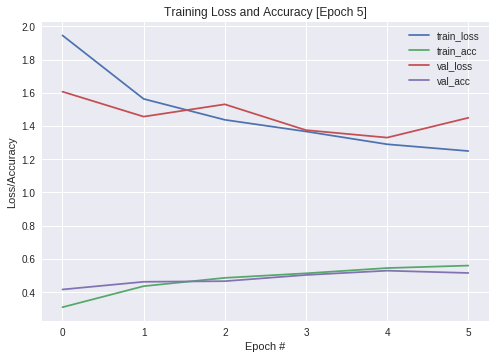

49000/49000 [==============================] - 18s 374us/sample - loss: 1.2495 - acc: 0.5598 - val_loss: 1.4494 - val_acc: 0.5153
Epoch 7/50
48896/49000 [============================>.] - ETA: 0s - loss: 1.2127 - acc: 0.5756

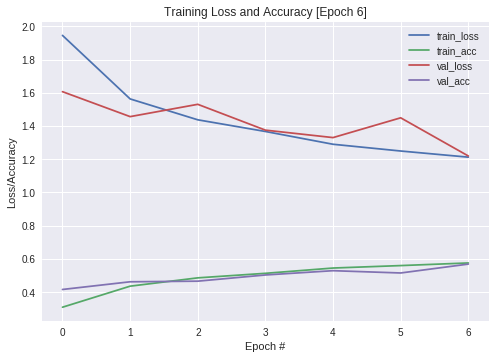

49000/49000 [==============================] - 18s 374us/sample - loss: 1.2125 - acc: 0.5757 - val_loss: 1.2197 - val_acc: 0.5688
Epoch 8/50
48896/49000 [============================>.] - ETA: 0s - loss: 1.1441 - acc: 0.5973

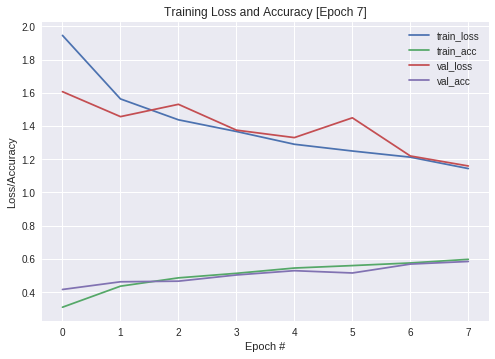

49000/49000 [==============================] - 19s 379us/sample - loss: 1.1439 - acc: 0.5974 - val_loss: 1.1595 - val_acc: 0.5846
Epoch 9/50
48832/49000 [============================>.] - ETA: 0s - loss: 1.0871 - acc: 0.6166

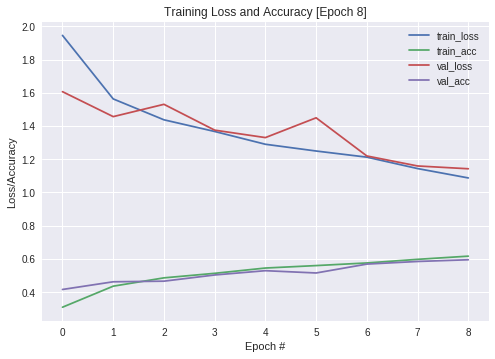

49000/49000 [==============================] - 18s 373us/sample - loss: 1.0874 - acc: 0.6166 - val_loss: 1.1426 - val_acc: 0.5949
Epoch 10/50
48896/49000 [============================>.] - ETA: 0s - loss: 1.0664 - acc: 0.6295

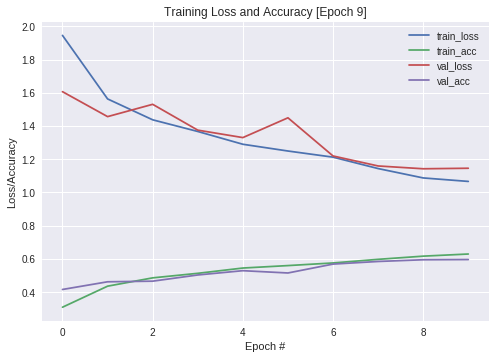

49000/49000 [==============================] - 18s 370us/sample - loss: 1.0665 - acc: 0.6295 - val_loss: 1.1457 - val_acc: 0.5962
Epoch 11/50
48960/49000 [============================>.] - ETA: 0s - loss: 1.0825 - acc: 0.6260

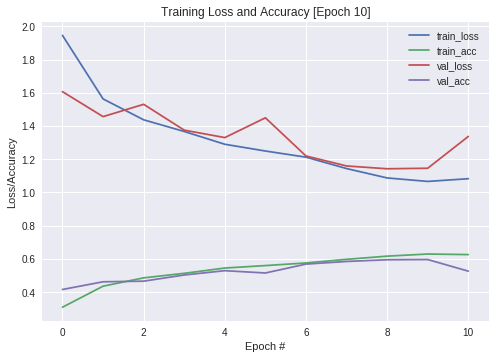

49000/49000 [==============================] - 18s 363us/sample - loss: 1.0828 - acc: 0.6259 - val_loss: 1.3372 - val_acc: 0.5263
Epoch 12/50
48832/49000 [============================>.] - ETA: 0s - loss: 1.0923 - acc: 0.6214

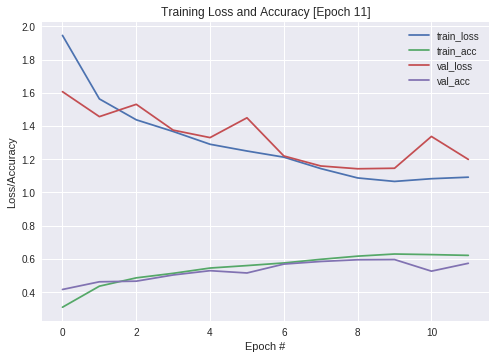

49000/49000 [==============================] - 18s 364us/sample - loss: 1.0920 - acc: 0.6213 - val_loss: 1.1990 - val_acc: 0.5736
Epoch 13/50
48896/49000 [============================>.] - ETA: 0s - loss: 1.0071 - acc: 0.6497

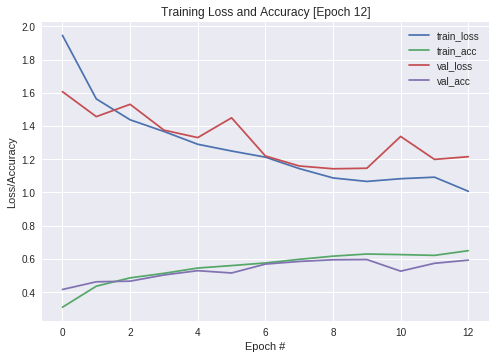

49000/49000 [==============================] - 17s 357us/sample - loss: 1.0073 - acc: 0.6495 - val_loss: 1.2154 - val_acc: 0.5926
Epoch 14/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.9476 - acc: 0.6715

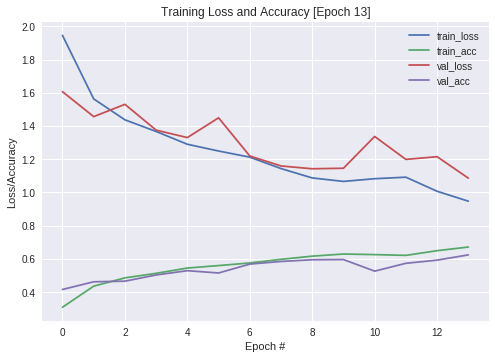

49000/49000 [==============================] - 17s 355us/sample - loss: 0.9475 - acc: 0.6715 - val_loss: 1.0863 - val_acc: 0.6243
Epoch 15/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.8753 - acc: 0.6934

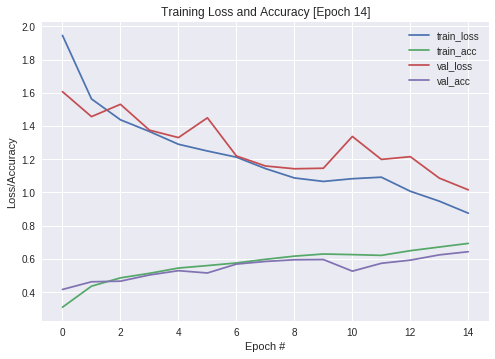

49000/49000 [==============================] - 17s 354us/sample - loss: 0.8752 - acc: 0.6934 - val_loss: 1.0158 - val_acc: 0.6434
Epoch 16/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.8314 - acc: 0.7102

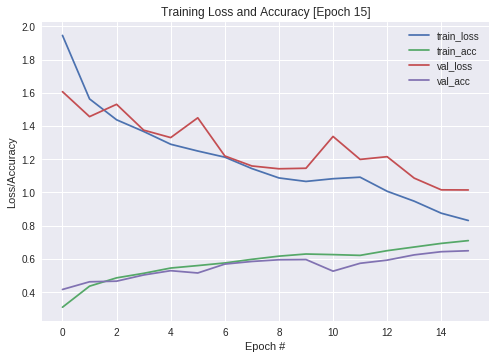

49000/49000 [==============================] - 17s 353us/sample - loss: 0.8313 - acc: 0.7101 - val_loss: 1.0151 - val_acc: 0.6491
Epoch 17/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.7679 - acc: 0.7319

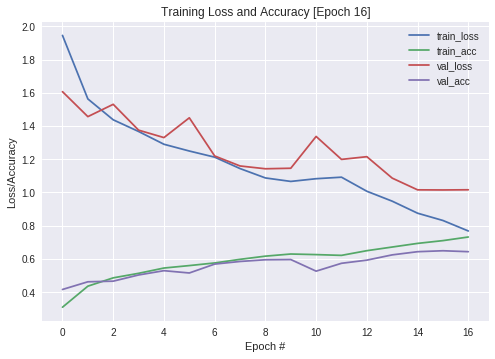

49000/49000 [==============================] - 17s 353us/sample - loss: 0.7681 - acc: 0.7319 - val_loss: 1.0162 - val_acc: 0.6435
Epoch 18/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.7332 - acc: 0.7432

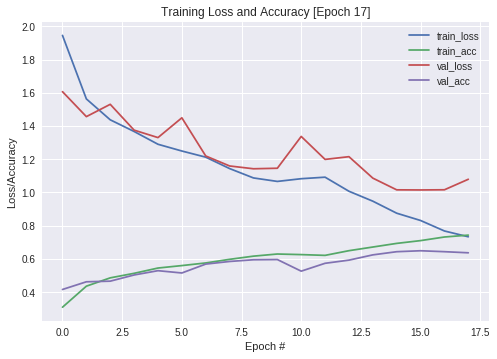

49000/49000 [==============================] - 17s 355us/sample - loss: 0.7332 - acc: 0.7432 - val_loss: 1.0794 - val_acc: 0.6368
Epoch 19/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.7437 - acc: 0.7398

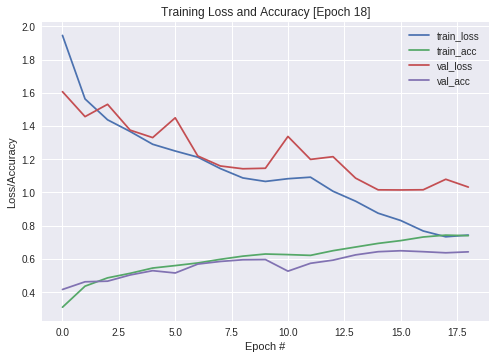

49000/49000 [==============================] - 17s 357us/sample - loss: 0.7435 - acc: 0.7399 - val_loss: 1.0324 - val_acc: 0.6425
Epoch 20/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.6710 - acc: 0.7638

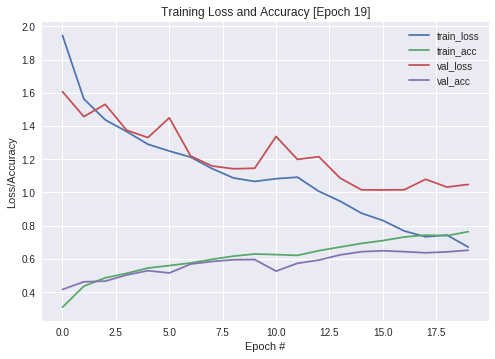

49000/49000 [==============================] - 17s 354us/sample - loss: 0.6711 - acc: 0.7639 - val_loss: 1.0483 - val_acc: 0.6521
Epoch 21/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.6519 - acc: 0.7712

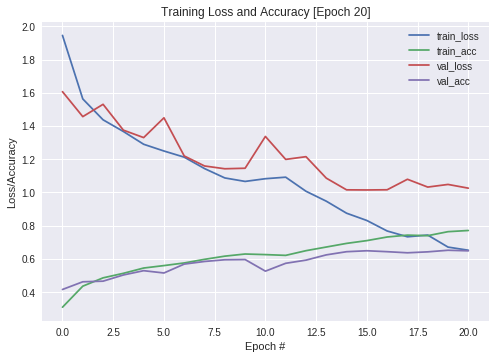

49000/49000 [==============================] - 17s 349us/sample - loss: 0.6523 - acc: 0.7711 - val_loss: 1.0259 - val_acc: 0.6487
Epoch 22/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.6014 - acc: 0.7863

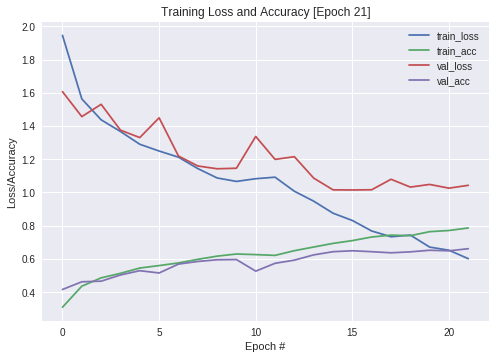

49000/49000 [==============================] - 17s 355us/sample - loss: 0.6013 - acc: 0.7863 - val_loss: 1.0431 - val_acc: 0.6614
Epoch 23/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.5711 - acc: 0.7979

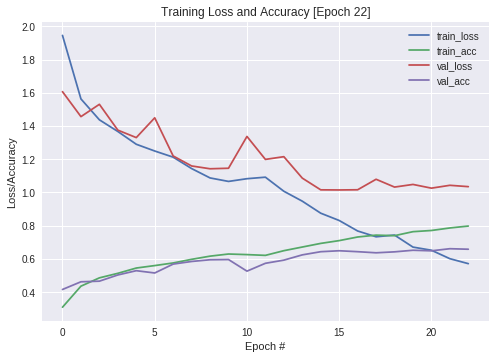

49000/49000 [==============================] - 17s 352us/sample - loss: 0.5715 - acc: 0.7978 - val_loss: 1.0350 - val_acc: 0.6583
Epoch 24/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.5667 - acc: 0.8007

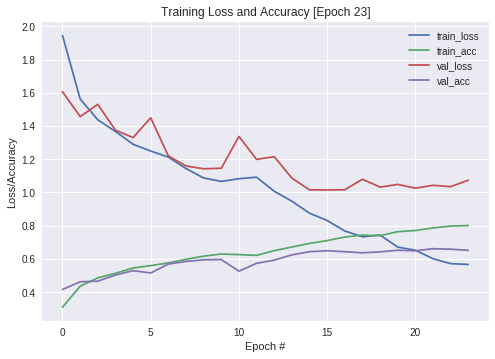

49000/49000 [==============================] - 17s 355us/sample - loss: 0.5668 - acc: 0.8007 - val_loss: 1.0739 - val_acc: 0.6519
Epoch 25/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.5564 - acc: 0.8040

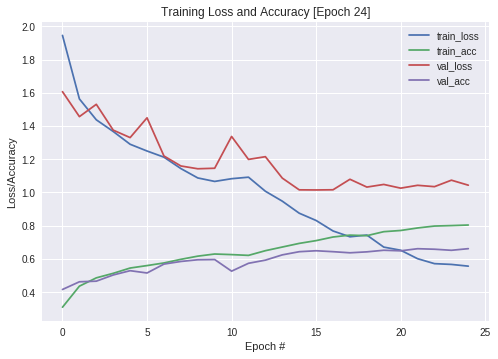

49000/49000 [==============================] - 18s 364us/sample - loss: 0.5564 - acc: 0.8040 - val_loss: 1.0437 - val_acc: 0.6617
Epoch 26/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.5050 - acc: 0.8208

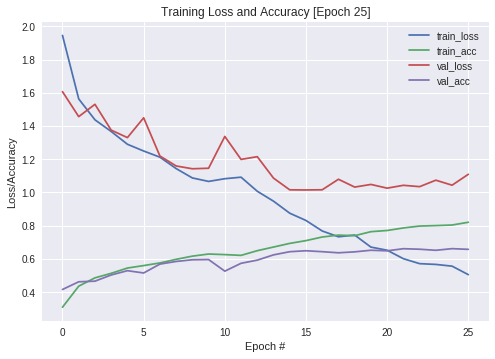

49000/49000 [==============================] - 17s 353us/sample - loss: 0.5052 - acc: 0.8207 - val_loss: 1.1094 - val_acc: 0.6576
Epoch 27/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.4744 - acc: 0.8317

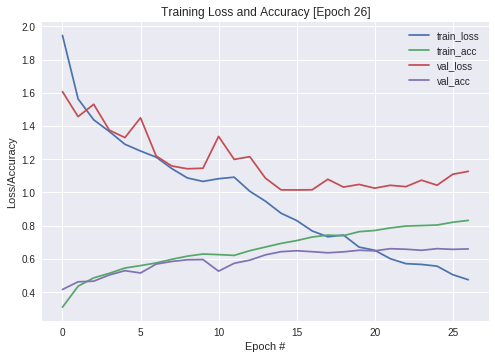

49000/49000 [==============================] - 17s 350us/sample - loss: 0.4746 - acc: 0.8317 - val_loss: 1.1272 - val_acc: 0.6601
Epoch 28/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.4606 - acc: 0.8361

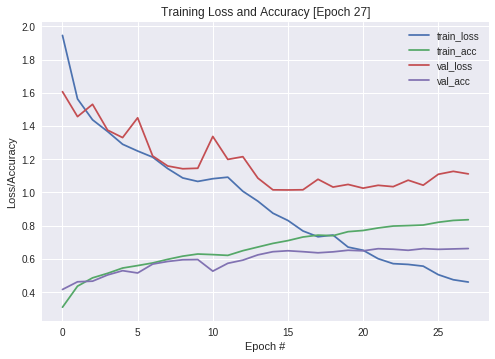

49000/49000 [==============================] - 17s 355us/sample - loss: 0.4608 - acc: 0.8360 - val_loss: 1.1118 - val_acc: 0.6625
Epoch 29/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.4407 - acc: 0.8429

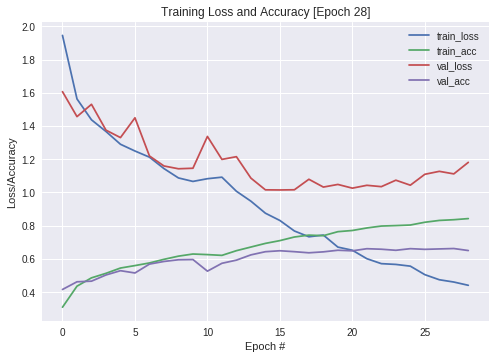

49000/49000 [==============================] - 17s 353us/sample - loss: 0.4411 - acc: 0.8427 - val_loss: 1.1813 - val_acc: 0.6504
Epoch 30/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.4253 - acc: 0.8486

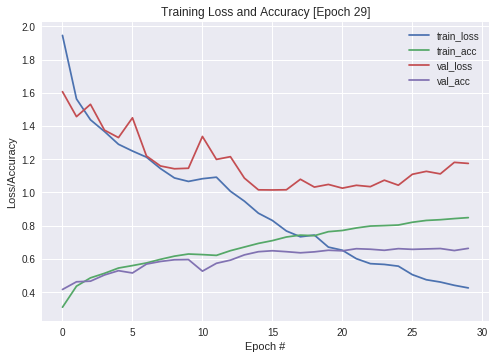

49000/49000 [==============================] - 18s 358us/sample - loss: 0.4254 - acc: 0.8486 - val_loss: 1.1749 - val_acc: 0.6635
Epoch 31/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.4227 - acc: 0.8498

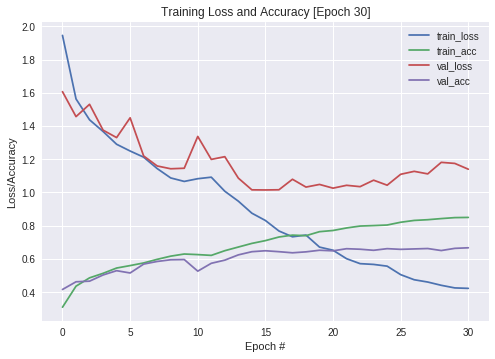

49000/49000 [==============================] - 17s 356us/sample - loss: 0.4227 - acc: 0.8498 - val_loss: 1.1400 - val_acc: 0.6670
Epoch 32/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.3930 - acc: 0.8608

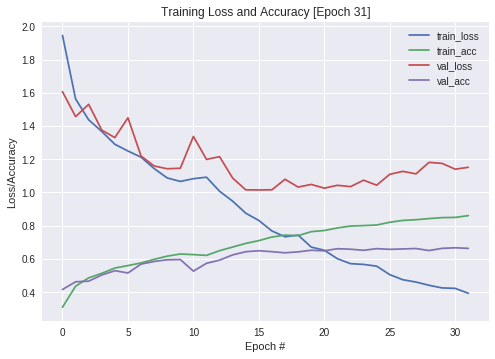

49000/49000 [==============================] - 17s 349us/sample - loss: 0.3932 - acc: 0.8607 - val_loss: 1.1516 - val_acc: 0.6635
Epoch 33/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.3718 - acc: 0.8680

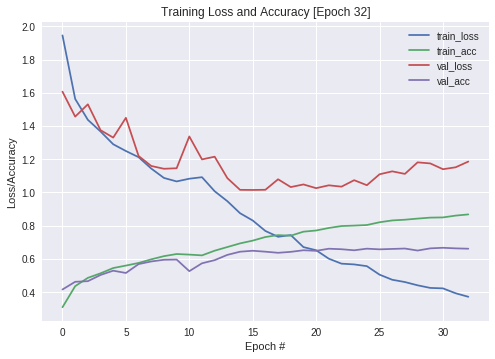

49000/49000 [==============================] - 18s 358us/sample - loss: 0.3720 - acc: 0.8679 - val_loss: 1.1860 - val_acc: 0.6614
Epoch 34/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.3504 - acc: 0.8752

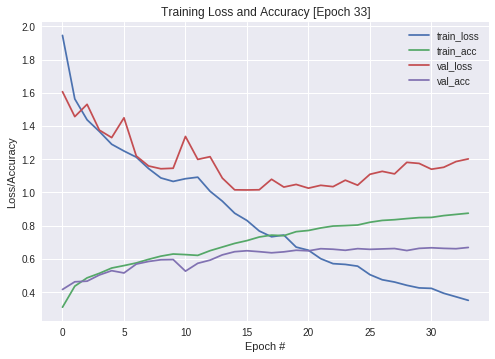

49000/49000 [==============================] - 17s 351us/sample - loss: 0.3506 - acc: 0.8751 - val_loss: 1.2021 - val_acc: 0.6689
Epoch 35/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.3406 - acc: 0.8796

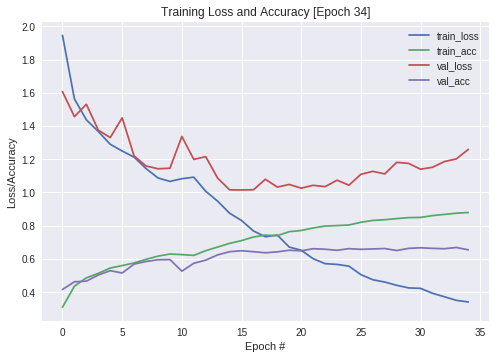

49000/49000 [==============================] - 17s 354us/sample - loss: 0.3408 - acc: 0.8795 - val_loss: 1.2594 - val_acc: 0.6546
Epoch 36/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.3285 - acc: 0.8839

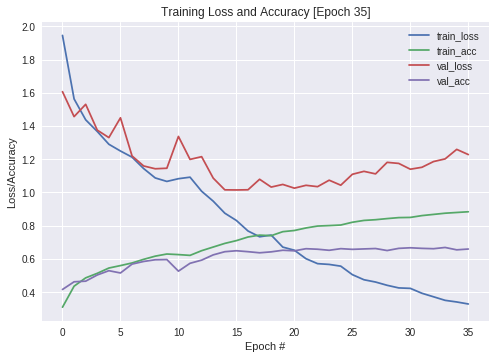

49000/49000 [==============================] - 17s 354us/sample - loss: 0.3286 - acc: 0.8839 - val_loss: 1.2281 - val_acc: 0.6595
Epoch 37/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.3155 - acc: 0.8882

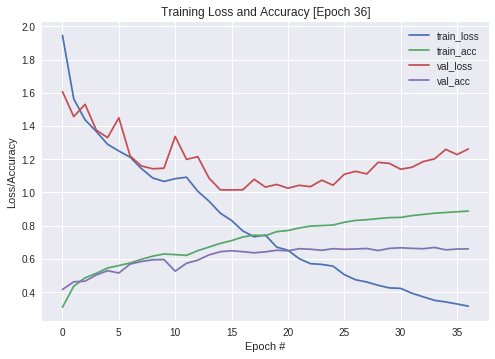

49000/49000 [==============================] - 18s 357us/sample - loss: 0.3156 - acc: 0.8881 - val_loss: 1.2617 - val_acc: 0.6605
Epoch 38/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.3111 - acc: 0.8899

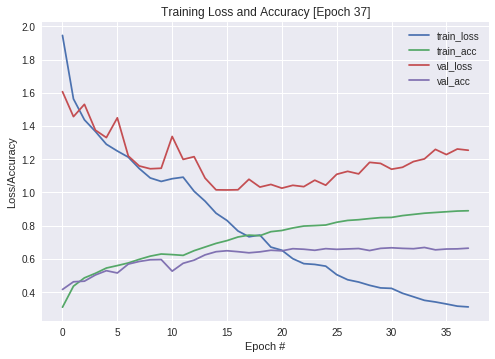

49000/49000 [==============================] - 18s 359us/sample - loss: 0.3110 - acc: 0.8899 - val_loss: 1.2542 - val_acc: 0.6645
Epoch 39/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.2915 - acc: 0.8956

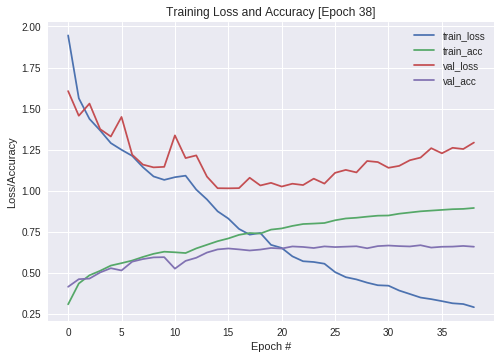

49000/49000 [==============================] - 17s 352us/sample - loss: 0.2917 - acc: 0.8954 - val_loss: 1.2935 - val_acc: 0.6598
Epoch 40/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.2822 - acc: 0.8983

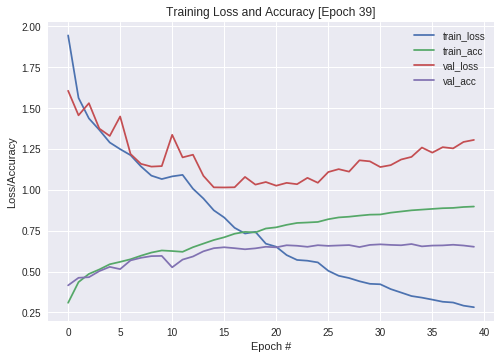

49000/49000 [==============================] - 17s 351us/sample - loss: 0.2823 - acc: 0.8983 - val_loss: 1.3059 - val_acc: 0.6522
Epoch 41/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.2748 - acc: 0.9023

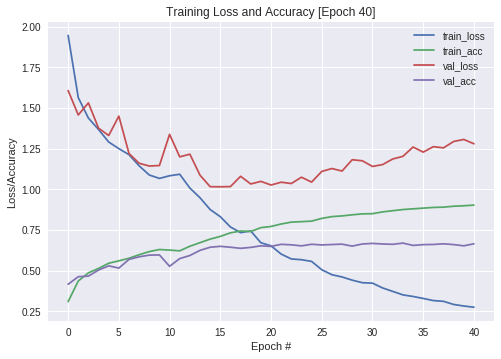

49000/49000 [==============================] - 18s 358us/sample - loss: 0.2748 - acc: 0.9023 - val_loss: 1.2793 - val_acc: 0.6647
Epoch 42/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.2579 - acc: 0.9082

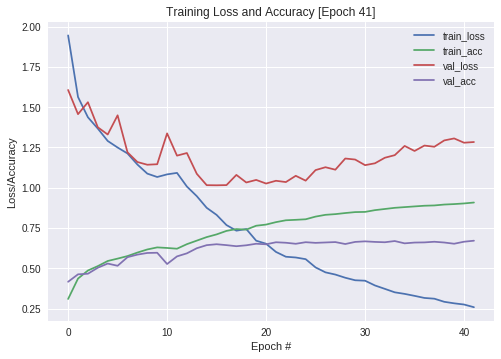

49000/49000 [==============================] - 17s 354us/sample - loss: 0.2581 - acc: 0.9080 - val_loss: 1.2836 - val_acc: 0.6710
Epoch 43/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.2573 - acc: 0.9091

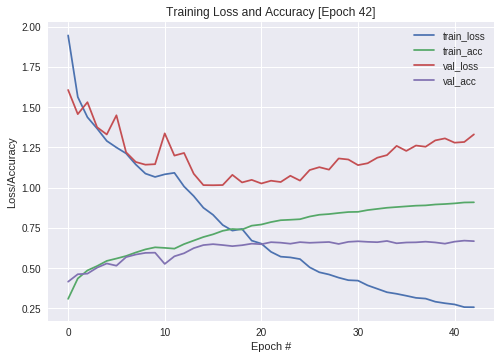

49000/49000 [==============================] - 18s 366us/sample - loss: 0.2576 - acc: 0.9090 - val_loss: 1.3309 - val_acc: 0.6678
Epoch 44/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.2347 - acc: 0.9171

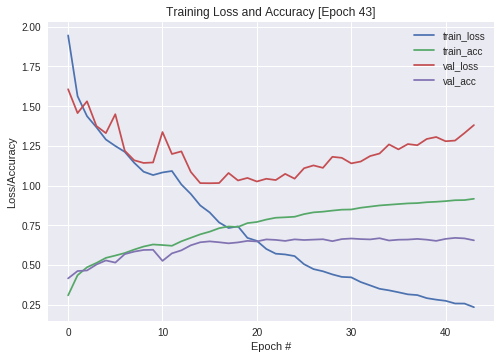

49000/49000 [==============================] - 17s 354us/sample - loss: 0.2347 - acc: 0.9171 - val_loss: 1.3811 - val_acc: 0.6556
Epoch 45/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.2227 - acc: 0.9208

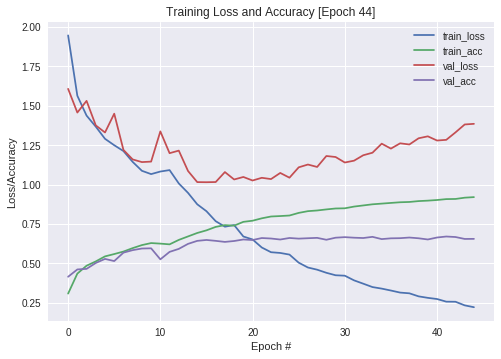

49000/49000 [==============================] - 17s 351us/sample - loss: 0.2229 - acc: 0.9207 - val_loss: 1.3851 - val_acc: 0.6561
Epoch 46/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.2297 - acc: 0.9191

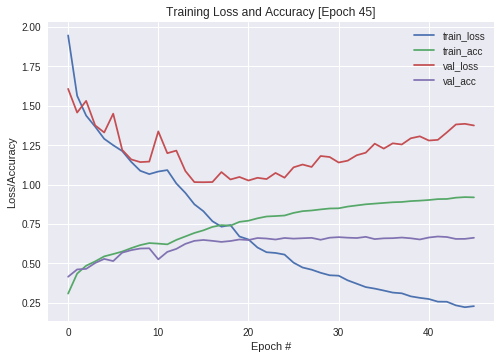

49000/49000 [==============================] - 17s 349us/sample - loss: 0.2297 - acc: 0.9192 - val_loss: 1.3747 - val_acc: 0.6630
Epoch 47/50
48832/49000 [============================>.] - ETA: 0s - loss: 0.2113 - acc: 0.9265

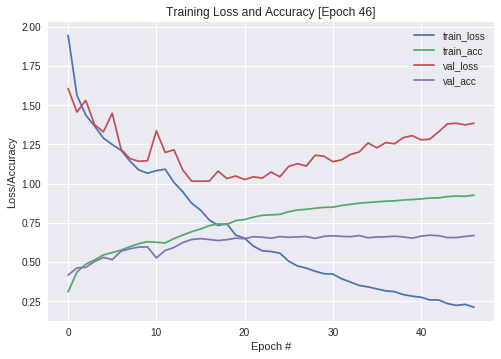

49000/49000 [==============================] - 17s 349us/sample - loss: 0.2116 - acc: 0.9264 - val_loss: 1.3854 - val_acc: 0.6690
Epoch 48/50
48960/49000 [============================>.] - ETA: 0s - loss: 0.2024 - acc: 0.9271

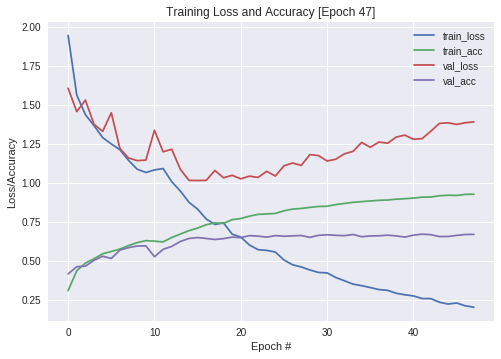

49000/49000 [==============================] - 17s 352us/sample - loss: 0.2026 - acc: 0.9271 - val_loss: 1.3909 - val_acc: 0.6697
Epoch 49/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9321

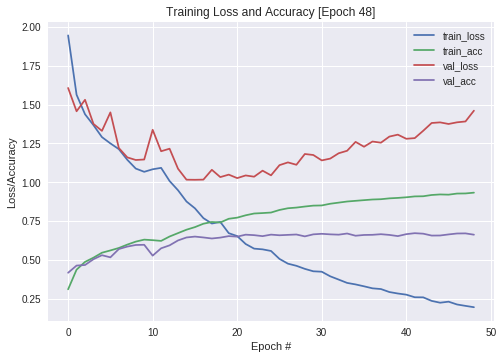

49000/49000 [==============================] - 18s 357us/sample - loss: 0.1940 - acc: 0.9322 - val_loss: 1.4605 - val_acc: 0.6613
Epoch 50/50
48896/49000 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9336

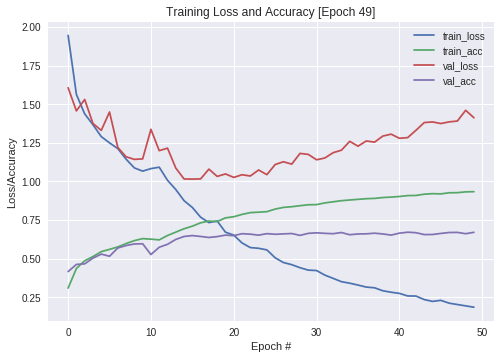

49000/49000 [==============================] - 17s 357us/sample - loss: 0.1853 - acc: 0.9335 - val_loss: 1.4121 - val_acc: 0.6703


In [19]:
initial_model, batch = train()


In [0]:
# from tensorflow.keras.utils import plot_model
# print(initial_model.summary())
# plot_model(initial_model, to_file='model.png', show_shapes=True)

# **Pruning**

In [20]:
import numpy as np
from tensorflow_model_optimization.sparsity import keras as sparsity


print(initial_model._is_graph_network)
# print(initial_model.Model)

print('Pruning')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

with tf.device('/device:GPU:0'):
  epochs = 4
  # num_train_samples = self.X_train.shape[0]
  end_step = np.ceil(1.0 * X_train.shape[0] / 64).astype(np.int32) * epochs
  print(end_step)

  new_pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                    final_sparsity=0.90,
                                                    begin_step=0,
                                                    end_step=end_step,
                                                    frequency=100)
  }

  # new_pruning_params = {
  #       'pruning_schedule': sparsity.ConstantSparsity(0.75, begin_step=2000, frequency=100)
  # }
        # PolynomialDecay(initial_sparsity=0.2,
        #                                             final_sparsity=0.5,
        #                                             begin_step=0,
        #                                             end_step=end_step)

  new_pruned_model = sparsity.prune_low_magnitude(initial_model, **new_pruning_params)
  new_pruned_model.summary()

  new_pruned_model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      optimizer='adam',
      metrics=['accuracy'])


logdir = './'
print('Writing training logs to ' + logdir)

callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0),
    plot_losses
]



True
Pruning
Found GPU at: /device:GPU:0
3064
Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv2d_185  (None, 16, 16, 32)   1762        input[0][0]                      
__________________________________________________________________________________________________
prune_low_magnitude_batch_norma (None, 16, 16, 32)   129         prune_low_magnitude_conv2d_185[0]
__________________________________________________________________________________________________
prune_low_magnitude_re_lu (Prun multiple             1           prune_l

Train on 49000 samples, validate on 10000 samples
Epoch 1/4
48960/49000 [============================>.] - ETA: 0s - loss: 0.9959 - accuracy: 0.6575INFO:tensorflow:Summary name prune_low_magnitude_conv2d_185/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_185/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_186/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_186/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_187/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_187/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_188/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_188/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_189/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_189/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_190/mask:0/sparsity is illegal; using prune_lo

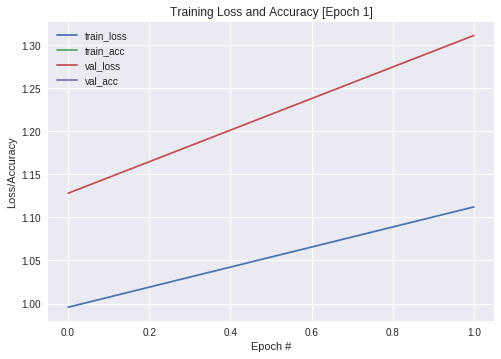

49000/49000 [==============================] - 86s 2ms/sample - loss: 1.1122 - accuracy: 0.6102 - val_loss: 1.3114 - val_accuracy: 0.5514
Epoch 3/4
48960/49000 [============================>.] - ETA: 0s - loss: 1.1218 - accuracy: 0.6060INFO:tensorflow:Summary name prune_low_magnitude_conv2d_185/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_185/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_186/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_186/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_187/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_187/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_188/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_188/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_189/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_189/mask_0/sparsity instead.
INFO:tensorflo

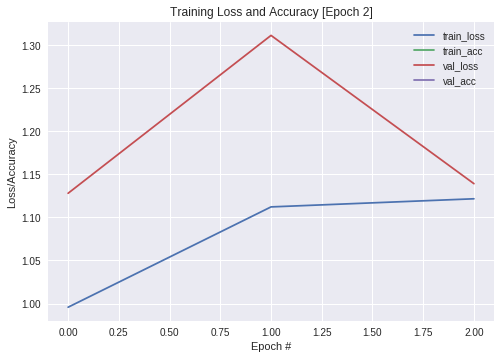

49000/49000 [==============================] - 86s 2ms/sample - loss: 1.1217 - accuracy: 0.6061 - val_loss: 1.1392 - val_accuracy: 0.5873
Epoch 4/4
48960/49000 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.6383INFO:tensorflow:Summary name prune_low_magnitude_conv2d_185/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_185/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_186/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_186/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_187/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_187/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_188/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_188/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_189/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_189/mask_0/sparsity instead.
INFO:tensorflo

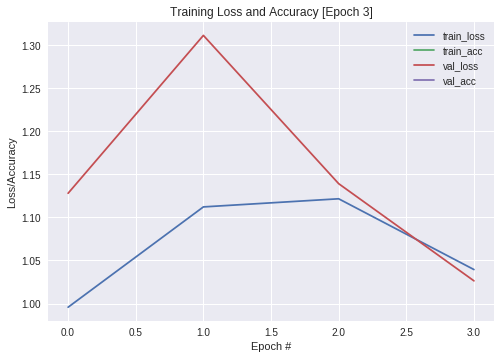

49000/49000 [==============================] - 86s 2ms/sample - loss: 1.0395 - accuracy: 0.6383 - val_loss: 1.0263 - val_accuracy: 0.6362
Test loss: 1.0263386617660522
Test accuracy: 0.6362
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 16, 16, 32)   896         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_265 (BatchN (None, 16, 16, 32)   128         conv2d_185[1][0]                 
__________________________________________________________________________________________________
r

In [21]:
new_pruned_model.fit(X_train, y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks,
          validation_data=(X_test, y_test))

score = new_pruned_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

final_model = sparsity.strip_pruning(new_pruned_model)
final_model.summary()

In [22]:

import numpy as np
names, params, percent = [] ,[], []
dash = '-' * 80
print(dash)
print('{:<20s}{:>40s}{:>12s}'.format('Name','Total Parameters','    Pruned %'))
print(dash)

for i, w in enumerate(final_model.get_weights()):
    print('{0:<40} {1:>10} {2:>18.3f}'.format(final_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100) )
    
    if(np.sum(w == 0) > 0):
      names.append(final_model.weights[i].name)
      params.append(w.size)
      percent.append(np.sum(w == 0))

print(params[0])
print(percent[0])

--------------------------------------------------------------------------------
Name                                        Total Parameters    Pruned %
--------------------------------------------------------------------------------
conv2d_185/kernel:0                             864             90.046
conv2d_185/bias:0                                32              0.000
batch_normalization_265/gamma:0                  32              0.000
batch_normalization_265/beta:0                   32              0.000
batch_normalization_265/moving_mean:0            32              0.000
batch_normalization_265/moving_variance:0         32              0.000
conv2d_186/kernel:0                            1024             90.039
conv2d_186/bias:0                                32              0.000
batch_normalization_266/gamma:0                  32              0.000
batch_normalization_266/beta:0                   32              0.000
batch_normalization_266/moving_mean:0            32   

In [23]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(x=names,
                y=params,
                name='Total Parameters',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=names,
                y=percent,
                name='Pruned Parameters',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='MobilenetV2 Pruned Parameters',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Parameters',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

Size of the original model after compression: 2.26 Mb
Size of the pruned model after compression: 2.25 Mb


**Quantization**

In [0]:

converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

tflite_quant_model = converter.convert()

tflite_quant_model_file = '/tmp/sparse_mnist_quant.tflite'
with open(tflite_quant_model_file, 'wb') as f:
  f.write(tflite_quant_model)

In [25]:
import zipfile 

# models = [[initial_model,'initial_model']
#           ,[final_model,'final_model']
#           ,[new_pruned_model,'new_pruned_model']]
models = [[final_model,'final_model']]
size_before = []
size_after = []
for i in models:
  print(i[1])

  tf.keras.models.save_model(i[0], './'+i[1]+'.h5', 
                          include_optimizer=False)

  print("Size of the pruned model before compression: %.4f Mb" 
        % (os.path.getsize('./'+i[1]+'.h5') / float(2**20)))
  size_before.append(os.path.getsize('./'+i[1]+'.h5') / float(2**20))
  with zipfile.ZipFile('./'+i[1]+'.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write('./'+i[1]+'.h5')
  
  print("Size of the pruned model after compression: %.4f Mb" 
        % (os.path.getsize('./'+i[1]+'.zip') / float(2**20)))
  size_after.append(os.path.getsize('./'+i[1]+'.zip') / float(2**20))
  

import tempfile
_, zip_tflite = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip_tflite, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(tflite_quant_model_file)
print("Size of the tflite quantized model before compression: %.2f Mb" 
      % (os.path.getsize(tflite_quant_model_file) / float(2**20)))
size_before.append(os.path.getsize(tflite_quant_model_file) / float(2**20))
print("Size of the tflite quantized model after compression: %.2f Mb" 
      % (os.path.getsize(zip_tflite) / float(2**20)))
size_after.append(os.path.getsize(zip_tflite) / float(2**20))

final_model
Size of the pruned model before compression: 9.1578 Mb
Size of the pruned model after compression: 2.1585 Mb
Size of the tflite quantized model before compression: 2.20 Mb
Size of the tflite quantized model after compression: 0.56 Mb


In [26]:
import plotly.graph_objects as go

months = ['Pruned', 'Quantized']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=months,
    y=size_before,
    name='Before',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=months,
    y=size_after,
    name='After',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(
    yaxis=dict(
        title='Size (MB)',
        titlefont_size=16,
        tickfont_size=14,
    ),
    barmode='group', xaxis_tickangle=-45)
fig.show()

Size of the tflite model before compression: 2.31 Mb
Size of the tflite model after compression: 0.52 Mb
